##Classify faces as man or woman
We'll load a bunch of images of male and female faces from DuckDuckGo to build our training set of images. Then we'll use those images to fine-tune the Resnet18 model, a neural net pretrained on ImageNet data. After training on our set of male/female face images, the Resnet18 model will be able to infer and classify the gender of a given image as a man or woman with high confidence.

In [7]:
!pip install -Uqq fastai duckduckgo_search

In [8]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [9]:
urls = search_images('man face', max_images=1)
urls[0]

Searching for 'man face'


'https://www.maxpixel.net/static/photo/2x/Male-Man-Rugged-Portrait-Face-Handsome-Guy-White-6153298.jpg'

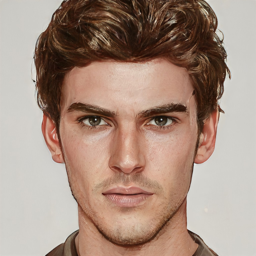

In [10]:
from fastdownload import download_url
dest = 'man.jpeg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'woman face'


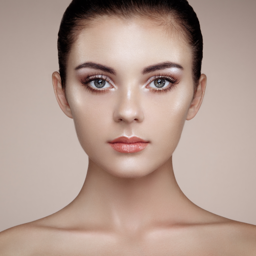

In [11]:
urls = search_images('woman face', max_images=1)
dest = 'woman.jpeg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [12]:
labels = 'man', 'woman'
races = 'white', 'black', 'asian', 'latin'
path = Path('man_or_woman')

for label in labels:
  for race in races:
    dest = (path/label)
    dest.mkdir(exist_ok=True, parents=True)
    term = race + " " + label + " face"
    download_images(dest, urls=search_images(term, 60))
    download_images(dest, urls=search_images("old " + term, 20))
    resize_images(path/label, max_size=400, dest=path/label)

Searching for 'white man face'
Searching for 'old white man face'
Searching for 'black man face'
Searching for 'old black man face'
Searching for 'asian man face'
Searching for 'old asian man face'
Searching for 'latin man face'
Searching for 'old latin man face'
Searching for 'white woman face'
Searching for 'old white woman face'
Searching for 'black woman face'
Searching for 'old black woman face'
Searching for 'asian woman face'
Searching for 'old asian woman face'
Searching for 'latin woman face'
Searching for 'old latin woman face'


In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

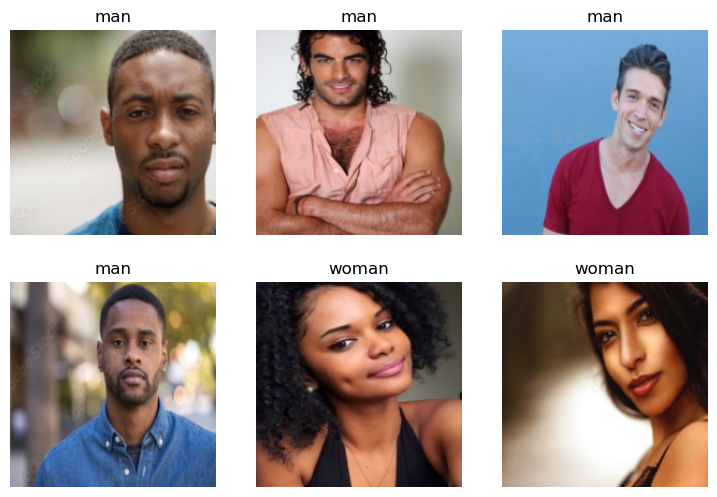

In [58]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms=[RandomResizedCrop(192, min_scale=0.6)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

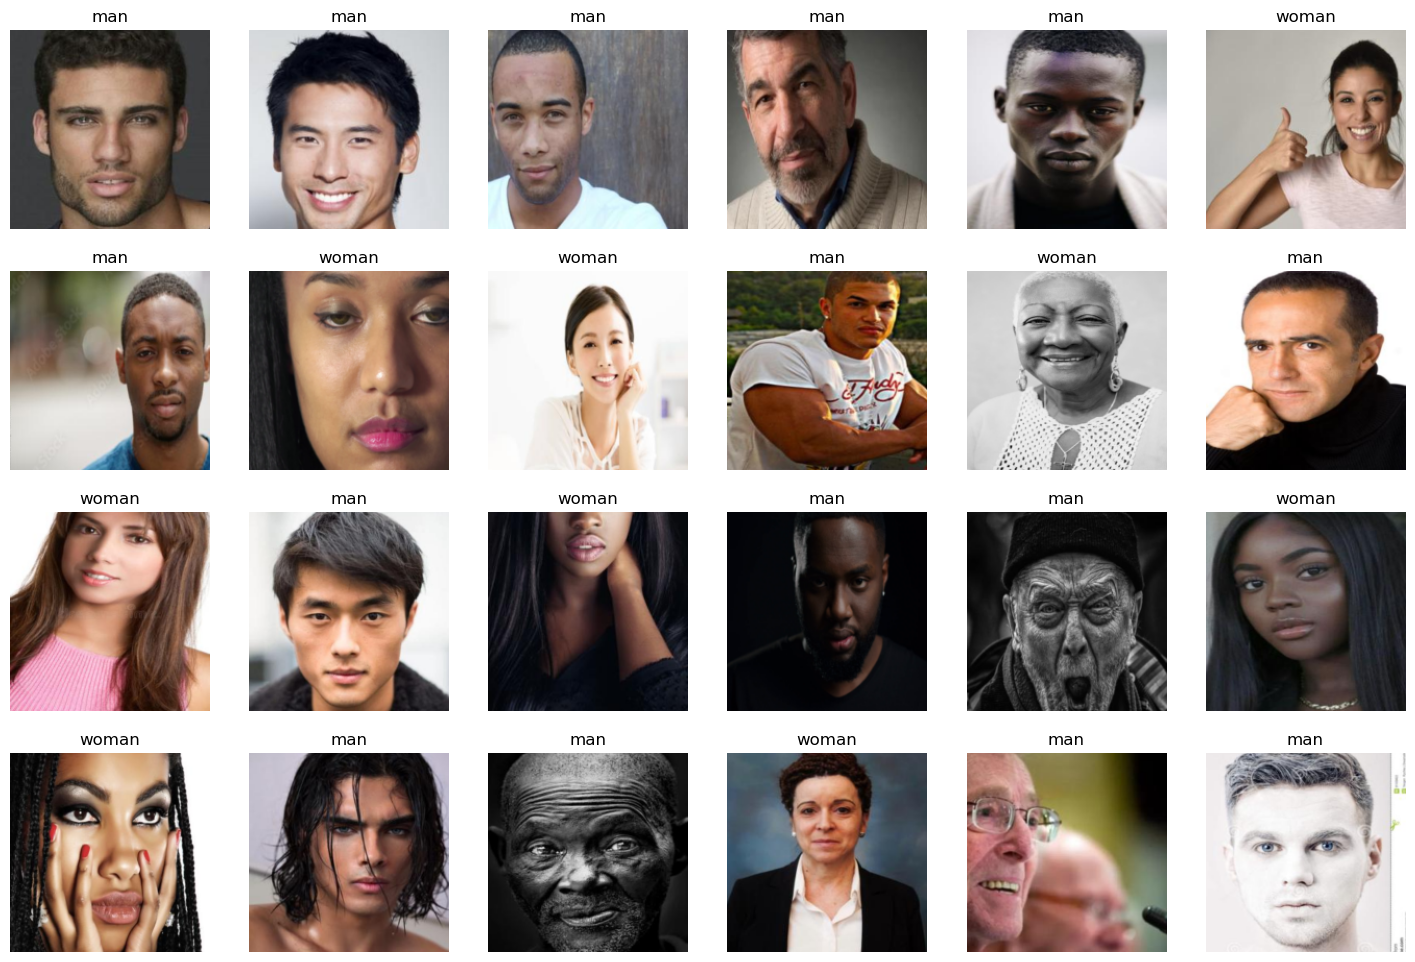

In [59]:
dls.show_batch(max_n=24)

In [60]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

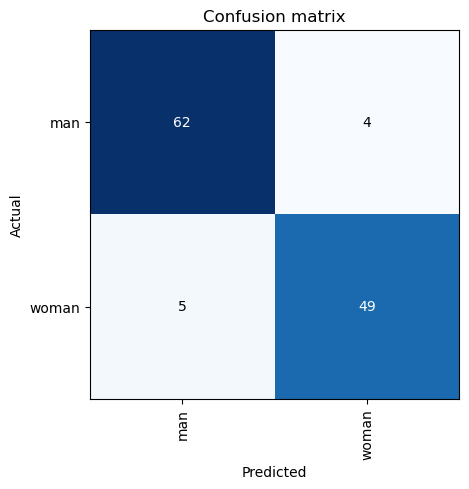

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

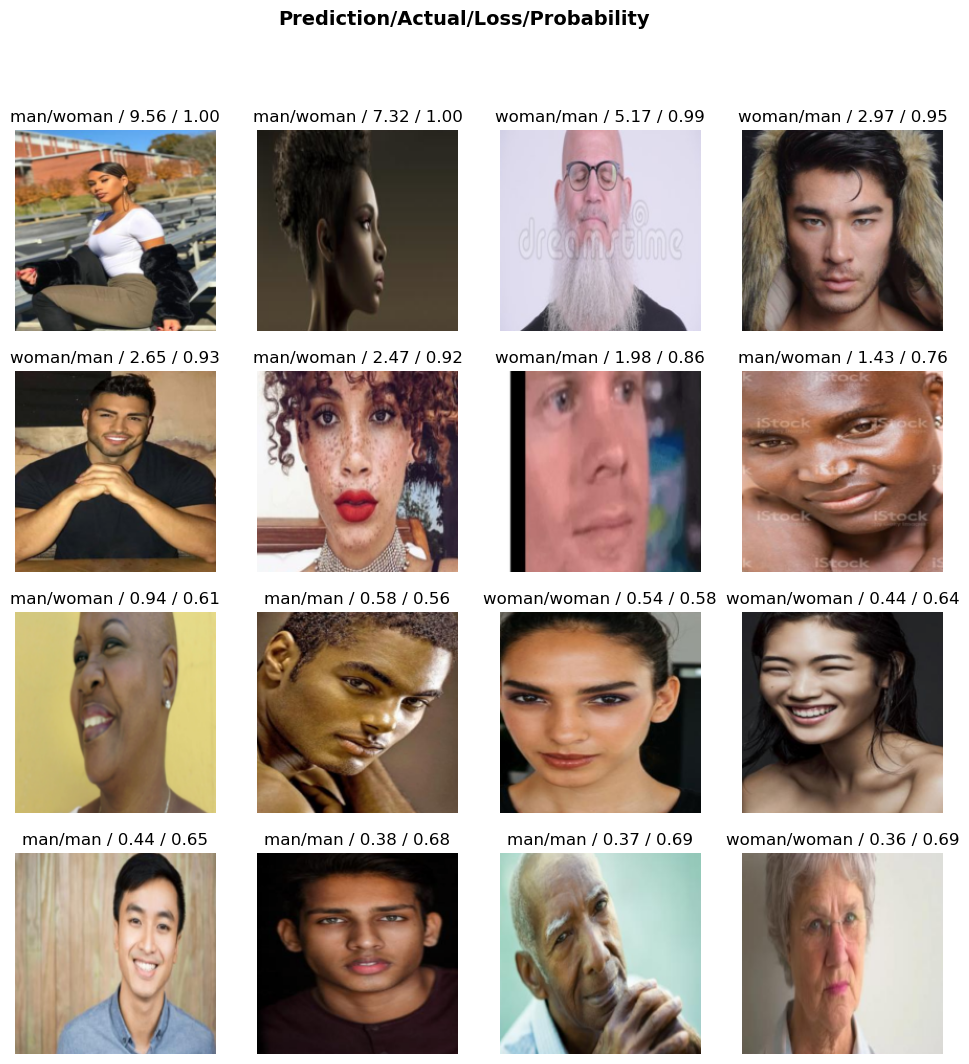

In [62]:
interp.plot_top_losses(16, nrows=4)

In [63]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [64]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [65]:
from IPython import display
def classify_image(image_path):
  precticted_gender, _, probs = learn.predict(PILImage.create(image_path))
  print(f"This is a: {precticted_gender}.")
  print(f"Probability it's a man: {probs[0]:.4f}")
  image = Image.open(image_path).to_thumb(256, 256)
  display.display(image)

This is a: man.
Probability it's a man: 1.0000


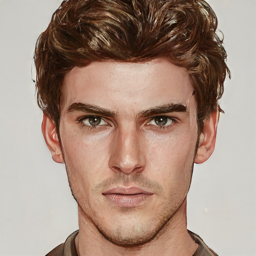

This is a: woman.
Probability it's a man: 0.0000


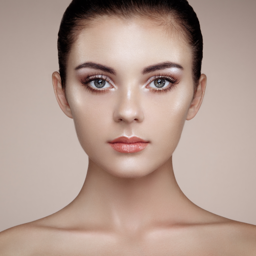

In [ ]:
genders = 'man', 'woman'

for gender in genders:
  image_path = f"{gender}.jpg"
  classify_image(image_path)

In [66]:
learn.export()

In [67]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [68]:
learn_inf = load_learner(path/'export.pkl')

In [69]:
learn_inf.predict("man.jpeg")

('man', tensor(0), tensor([1.0000e+00, 1.6896e-06]))

In [70]:
learn_inf.dls.vocab

['man', 'woman']